## Intro
This is the exploration of using GBDT/RF + LR to predict biClassification problems. The paper is [Practical Lessons from Predicting Clicks on Ads at Facebook,2014](http://quinonero.net/Publications/predicting-clicks-facebook.pdf)

Steps:
* Generate the dataset
* Split the dataset into 3 parts: GBDT/RF, LR and test dataset
* Apply GBDT/LR to dataset
* OneHotEncoding the tree leaf indices
* Train the oneHotEncoding with LR
* Compare the AUC of different methods: GBDT+LR, RF + LR, LR, GBDT, RF

## Import packages

In [1]:
import numpy as np
np.random.seed(10)
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomTreesEmbedding,\
GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from icecream import ic

## Make dataset

In [2]:
# Generate the dataset as 80000 samplew with 20 features
X,y = make_classification(n_samples= 80000, n_features= 20)
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2)
X_train,X_train_lr, y_train, y_train_lr = train_test_split(X_train, y_train, test_size=0.5)

## Random Forest +LR
More features in raw data, more features to  LR,more parameter =>the upper limitations of model is higher

In [3]:
n_estimator =10
rf = RandomForestClassifier(max_depth =3, n_estimators = n_estimator)
rf.fit(X_train, y_train)

# OneHotEncoder
rf_enc = OneHotEncoder(categories ='auto')
# Apply trees in the forest to X, return leaf indices.
ic(rf.apply(X_train)[0])

rf_enc.fit(rf.apply(X_train))

# Create LR model
rf_lm = LogisticRegression(solver ='lbfgs',max_iter =1000)
# from original 20 features to 20000 features
# print(rf_enc.transform(rf.apply(X_train)))
temp = rf.apply(X_train_lr)
# ic(temp)
print('shape of temp:', temp.shape)
rf_lm.fit(rf_enc.transform(temp), y_train_lr)
# predict_proba return the class probabilities of the input samples.
y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:,1]
fpr_rf_lm, tpr_rf_lm,_ = roc_curve(y_test, y_pred_rf_lm)

ic| rf.apply(X_train)[0]: array([ 4, 14, 10, 14, 10, 13, 14, 13, 10,  4], dtype=int64)


shape of temp: (32000, 10)


## GBDT + LR
Gradient Boosting Decision Tree  
**Paper**
[Greedy function Approximation-A Gradient Boosting Machine](https://projecteuclid.org/download/pdf_1/euclid.aos/1013203451)

In [4]:
gbdt = GradientBoostingClassifier(n_estimators = n_estimator)
gbdt.fit(X_train, y_train)

gbdt_enc = OneHotEncoder(categories='auto')
gbdt_enc.fit(gbdt.apply(X_train)[:,:,0])

temp = gbdt.apply(X_train_lr)[:,:,0]
gbdt_lm = LogisticRegression(solver='lbfgs', max_iter= 1000)
gbdt_lm.fit(gbdt_enc.transform(temp), y_train_lr)
y_pred_grd_lm = gbdt_lm.predict_proba(gbdt_enc.transform(gbdt.apply(X_test)[:,:,0]))[:,1]
fpr_gbdt_lm, tpr_gbdt_lm, _ = roc_curve(y_test, y_pred_grd_lm)

## GBDT only

In [5]:
y_pred_grd =gbdt.predict_proba(X_test)[:,1]
fpr_gbdt, tpr_gbdt,_ = roc_curve(y_test, y_pred_grd)

## LR only to predict

In [6]:
lr = LogisticRegression(solver='lbfgs', n_jobs=4, max_iter =1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
auc = roc_auc_score(y_test,y_pred_lr)
auc

0.9733458439259302

## RF only

In [7]:
y_pred_rf = rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf,_ = roc_curve(y_test, y_pred_rf) 

## Compare the results of differenct models

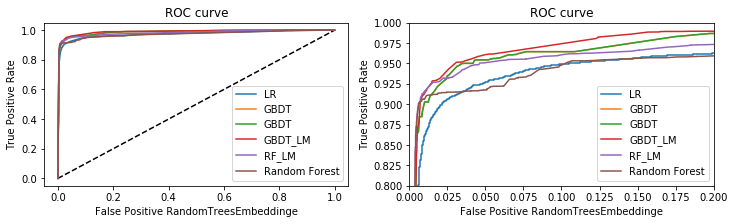

In [8]:
fig,ax= plt.subplots(1,2,figsize=(12,3))
for i in range(2):
    ax[i].plot([0,1],[0,1],'k--')
    
    if i==1:
        ax[i].set_xlim(0, 0.2)
        ax[i].set_ylim(0.8, 1)
    ax[i].plot(fpr_lr, tpr_lr, label ='LR')
    ax[i].plot(fpr_gbdt, tpr_gbdt, label ='GBDT')
    ax[i].plot(fpr_gbdt, tpr_gbdt, label ='GBDT')
    ax[i].plot(fpr_gbdt_lm, tpr_gbdt_lm, label ='GBDT_LM')
    ax[i].plot(fpr_rf_lm, tpr_rf_lm, label ='RF_LM')
    ax[i].plot(fpr_rf, tpr_rf, label ='Random Forest')
    ax[i].set_xlabel('False Positive RandomTreesEmbeddinge')
    ax[i].set_ylabel('True Positive Rate')
    ax[i].set_title('ROC curve')
    ax[i].legend(loc='best')
plt.show()

In [9]:
for i in range(2):
    print (i)

0
1
